In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
import pandas as pd
import os
from pathlib import Path

output_dir = Path("/content/drive/MyDrive/DMS/data/splits/24frame_windows")
train_df = pd.read_csv(output_dir / "final_train.csv")
val_df = pd.read_csv(output_dir / "final_val.csv")
test_df = pd.read_csv(output_dir / "final_test.csv")

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

<ipython-input-92-6e8dd4e19f98>:6: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(output_dir / "final_train.csv")


(83451, 14)
(15085, 14)
(24226, 14)


In [83]:
def valid_framepath(df):
    # frame_path 열을 기준으로 실제 파일이 존재하는지 확인
    df['valid_path'] = df['frame_path'].apply(lambda x: os.path.exists(x))

    # 유효하지 않은 경로만 확인
    invalid = df[~df['valid_path']]
    print(f"❌ 불러올 수 없는 이미지 수: {len(invalid)}")

    # 예시로 5개 확인
    display(invalid[['label', 'frame_path']].head())

In [93]:
valid_framepath(test_df)

❌ 불러올 수 없는 이미지 수: 490


,label,frame_path
23736,text,/content/drive/MyDrive/DMS/data/DMD/dmd_frames...
23737,text,/content/drive/MyDrive/DMS/data/DMD/dmd_frames...
23738,text,/content/drive/MyDrive/DMS/data/DMD/dmd_frames...
23739,text,/content/drive/MyDrive/DMS/data/DMD/dmd_frames...
23740,text,/content/drive/MyDrive/DMS/data/DMD/dmd_frames...


In [72]:
train_df[(train_df['valid_path']==False) & (train_df['label']=='yawn') & (train_df['dataset']=='yawDD')].frame_path[82543]

'/content/drive/MyDrive/DMS/data/YawDD dataset/YawDD_adjusted_frames_resized/yawn_mirror/1-FemaleNoGlasses-Yawning-clip-0/frame000024.jpg'

In [70]:
train_df[(train_df['valid_path']==True) & (train_df['label']=='yawn') & (train_df['dataset']=='yawDD')].frame_path[78504]

'/content/drive/MyDrive/DMS/data/processed/yawDD_adjusted_frames_resized/yawn_mirror/1-FemaleNoGlasses-Yawning-clip-0/frame000000.jpg'

In [74]:
train_df[(train_df['valid_path']==False) & (train_df['label']=='yawn') & (train_df['dataset']=='DMD')]

,frame_path,label,camera,clip_id,frame_no,dataset,groups_24,mar,ear,yaw,pitch,phone_detected,seven_group,subject_id,valid_path


- /DMD/ -> /processed/
- /YawDD dataset/YawDD_adjusted_frames_resized -> /processed/yawDD_adjusted_frames_resized

In [86]:
def modify_framepath(df):
    # 경로 치환
    df['frame_path'] = (
        df['frame_path']
        .str.replace('/DMD/', '/processed/', regex=False)
        .str.replace('/YawDD dataset/YawDD_adjusted_frames_resized', '/processed/yawDD_adjusted_frames_resized', regex=False)
    )

    # 확인
    print("📁 경로 변경 완료. 예시:")
    display(df['frame_path'].head())


In [96]:
df = test_df.copy()
modify_framepath(df)

📁 경로 변경 완료. 예시:


,frame_path
0,/content/drive/MyDrive/DMS/data/processed/dmd_...
1,/content/drive/MyDrive/DMS/data/processed/dmd_...
2,/content/drive/MyDrive/DMS/data/processed/dmd_...
3,/content/drive/MyDrive/DMS/data/processed/dmd_...
4,/content/drive/MyDrive/DMS/data/processed/dmd_...


In [97]:
valid_framepath(df)

❌ 불러올 수 없는 이미지 수: 0


,label,frame_path


In [98]:
df.shape

(24226, 15)

In [99]:
df = df.drop('valid_path', axis=1)
df.to_csv(output_dir / "test_framepath_fixed.csv")

In [ ]:
def modify_frame_path(df):
    # 'yawn' label을 가진 행들에 대해 frame_path 수정
    mask = (df['label'] == 'yawn') & (df['dataset'] == 'DMD')

    def fix_frame_path(path):
        parts = path.split('/')
        if len(parts) < 2:
            return path
        if parts[-2] in parts[-3]:
            # 중복된 디렉토리 제거
            return '/'.join(parts[:-2] + [parts[-1]])
        return path

    df.loc[mask, 'frame_path'] = df.loc[mask, 'frame_path'].apply(fix_frame_path)
    print(df.shape)

In [ ]:
modify_frame_path(train_df)
modify_frame_path(val_df)
modify_frame_path(test_df)

(82224, 14)
(14784, 14)
(23736, 14)


In [ ]:
train_df[(train_df['label'] == 'yawn') & (train_df['dataset'] == 'DMD')].frame_path[78840]

'/content/drive/MyDrive/DMS/data/processed/dmd_frames_resized/Yawn/gC-11(File11)_s5_face_2019-03-12-09;08;15_11_0.avi/frame000000.jpg'

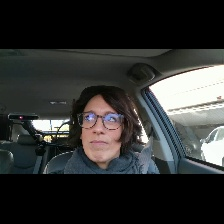

In [ ]:
from IPython.display import Image, display

# 이미지 경로
img_path = train_df[(train_df['label'] == 'yawn') & (train_df['dataset'] == 'DMD')].frame_path[78840]

# 이미지 출력
display(Image(filename=img_path))

In [ ]:
train_df.to_csv(output_dir / 'final_train.csv', index=False)
val_df.to_csv(output_dir / 'final_val.csv', index=False)
test_df.to_csv(output_dir / 'final_test.csv', index=False)

In [ ]:
# 1. DMD yawn 데이터 분리
dmd_yawn_df = all_df[(all_df['dataset'] == 'DMD') & (all_df['label'] == 'yawn')].copy()

# 2. 기존 split에서 DMD-yawn 제거
def remove_dmd_yawn(df):
    return df[~((df['dataset'] == 'DMD') & (df['label'] == 'yawn'))].copy()

train_df = remove_dmd_yawn(train_df)
val_df = remove_dmd_yawn(val_df)
test_df = remove_dmd_yawn(test_df)

# 3. subject_id 없으면 생성
if "subject_id" not in dmd_yawn_df.columns:
    dmd_yawn_df["subject_id"] = dmd_yawn_df.apply(extract_subject_id, axis=1)

# 4. 분할 기준
val_ids = {"gA-1", "gA-2", "gA-3", "gA-4"}
test_ids = {"gA-5", "gB-10", "gB-6", "gB-7", "gB-8", "gB-9", "gE-26"}

# 실제 존재하는 subject만 사용
existing_ids = set(dmd_yawn_df["subject_id"].unique())
val_ids = val_ids & existing_ids
test_ids = test_ids & existing_ids
train_ids = existing_ids - val_ids - test_ids

# 5. dmd_yawn을 split
dmd_yawn_train = dmd_yawn_df[dmd_yawn_df["subject_id"].isin(train_ids)]
dmd_yawn_val = dmd_yawn_df[dmd_yawn_df["subject_id"].isin(val_ids)]
dmd_yawn_test = dmd_yawn_df[dmd_yawn_df["subject_id"].isin(test_ids)]

# 6. 다시 결합
final_train = pd.concat([train_df, dmd_yawn_train], ignore_index=True)
final_val = pd.concat([val_df, dmd_yawn_val], ignore_index=True)
final_test = pd.concat([test_df, dmd_yawn_test], ignore_index=True)


In [ ]:
print(final_train.shape)
print(final_val.shape)
print(final_test.shape)

(97752, 14)
(15696, 14)
(25320, 14)


In [ ]:
WINDOW_SIZE = 12
print(final_train.shape[0] % WINDOW_SIZE == 0.0)
print(final_val.shape[0] % WINDOW_SIZE == 0.0)
print(final_test.shape[0] % WINDOW_SIZE == 0.0)

True
True
True


In [ ]:
final_train.shape[0]+final_val.shape[0]+final_test.shape[0]

138768

In [ ]:
output_dir = Path("/content/drive/MyDrive/DMS/data/splits/12frame_windows")

def save_csv(df, save_path):
    df = df.sort_values(by=["label", "dataset", "clip_id", "frame_no"]).reset_index(drop=True)
    df.to_csv(save_path, index=False)

In [ ]:
save_csv(final_train, output_dir / 'final_train.csv')
save_csv(final_train, output_dir / 'final_val.csv')
save_csv(final_train, output_dir / 'final_test.csv')

SyntaxError: invalid syntax (<ipython-input-29-4d02618d9938>, line 1)

In [ ]:
def extract_subject_id(row):
    if row["dataset"] == "DMD":
        return row["clip_id"].split("(")[0]  # 'gE-27(File27)_...' → 'gE-27'
    elif row["dataset"].lower().startswith("yawdd"):
        clip_head = row["clip_id"].split("-")[0]  # '1-Female...' → '1'
        return f"{row['camera']}_{clip_head}"
    return "UNKNOWN"

# 사람 ID 추출
for df in [final_train, final_val, final_test]:
    df["subject_id"] = df.apply(extract_subject_id, axis=1)

# 데이터셋별 고유 subject_id 추출
train_subjects = set(final_train["subject_id"].unique())
val_subjects = set(final_val["subject_id"].unique())
test_subjects = set(final_test["subject_id"].unique())

# 교집합 확인
overlap_train_val = train_subjects & val_subjects
overlap_train_test = train_subjects & test_subjects
overlap_val_test = val_subjects & test_subjects

# 결과 출력
print(f"🔁 train ∩ val 겹치는 사람 수: {len(overlap_train_val)}")
print(f"🔁 train ∩ test 겹치는 사람 수: {len(overlap_train_test)}")
print(f"🔁 val ∩ test 겹치는 사람 수: {len(overlap_val_test)}")

# 상세 목록 출력 (필요 시)
if overlap_train_val:
    print("\n🔍 train ∩ val 겹치는 ID:")
    print(sorted(overlap_train_val))


🔁 train ∩ val 겹치는 사람 수: 0
🔁 train ∩ test 겹치는 사람 수: 0
🔁 val ∩ test 겹치는 사람 수: 0


## DMD_yawn 파일명 수정

In [ ]:
import os
# 예시 경로 (내 드라이브에 추가된 경우)
root_path = "/content/drive/MyDrive/DMS/data/processed/dmd_frames_resized/Yawn"

# 폴더 구조 탐색
for dirpath, dirnames, filenames in os.walk(root_path):
    print(f"📁 {dirpath}")
    print(dirnames)
    break

📁 /content/drive/MyDrive/DMS/data/processed/dmd_frames_resized/Yawn
['gA-1(File1)_s5_face_2019-03-14-14;26;17_1_0.avi', 'gA-1(File1)_s5_face_2019-03-14-14;26;17_1_1.avi', 'gA-1(File1)_s5_face_2019-03-14-14;26;17_1_2.avi', 'gA-2(File2)_s5_face_2019-03-13-09;19;23_2_0.avi', 'gA-2(File2)_s5_face_2019-03-13-09;19;23_2_2.avi', 'gA-2(File2)_s5_face_2019-03-13-09;19;23_2_3.avi', 'gA-2(File2)_s5_face_2019-03-13-09;19;23_2_1.avi', 'gA-3(File3)_s5_face_2019-03-13-09;36;25_3_1.avi', 'gA-3(File3)_s5_face_2019-03-13-09;36;25_3_0.avi', 'gA-4(File4)_s5_face_2019-03-13-10;56;52_4_0.avi', 'gA-4(File4)_s5_face_2019-03-13-10;56;52_4_1.avi', 'gA-5(File5)_s5_face_2019-03-13-09;06;49_5_0.avi', 'gA-5(File5)_s5_face_2019-03-13-09;06;49_5_1.avi', 'gB-6(File6)_s5_face_2019-03-13-13;37;11_6_0.avi', 'gB-6(File6)_s5_face_2019-03-13-13;37;11_6_1.avi', 'gB-7(File7)_s5_face_2019-03-13-13;55;52_7_0.avi', 'gB-7(File7)_s5_face_2019-03-13-13;55;52_7_1.avi', 'gB-7(File7)_s5_face_2019-03-13-13;55;52_7_2.avi', 'gB-7(File7)_

형식:
- gZ-37(File31)_s4_face_2019-04-03-15;40;42_37_9.avi

In [ ]:
# 경로 설정
base_dir = Path("/content/drive/MyDrive/DMS/data/processed/dmd_frames_resized/Yawn")

# 매핑 정보 (subject_id, file_number, optional session)
video_id_to_metadata = {
    "face_2019-03-07-16;31;48_9": ("gB-9", "File9", "s5"),
    "face_2019-03-12-09;08;15_11": ("gC-11", "File11", "s5"),
    "face_2019-03-12-09;18;58_14": ("gC-14", "File14", "s5"),
    "face_2019-03-12-10;03;00_13": ("gC-13", "File13", "s5"),
    "face_2019-03-12-10;35;20_10": ("gB-10", "File10", "s5"),
    "face_2019-03-12-11;03;23_15": ("gC-15", "File15", "s5"),
    "face_2019-03-13-09;06;49_5": ("gA-5", "File5", "s5"),
    "face_2019-03-13-09;19;23_2": ("gA-2", "File2", "s5"),
    "face_2019-03-13-09;36;25_3": ("gA-3", "File3", "s5"),
    "face_2019-03-13-10;56;52_4": ("gA-4", "File4", "s5"),
    "face_2019-03-13-13;37;11_6": ("gB-6", "File6", "s5"),
    "face_2019-03-13-13;55;52_7": ("gB-7", "File7", "s5"),
    "face_2019-03-13-14;10;09_8": ("gB-8", "File8", "s5"),
    "face_2019-03-13-14;17;28_10": ("gB-10", "File10", "s5"),
    "face_2019-03-14-09;56;52_12": ("gC-12", "File12", "s5"),
    "face_2019-03-14-14;26;17_1": ("gA-1", "File1", "s5"),
}

# 클립 폴더 이름 리네이밍
for folder in base_dir.iterdir():
    if folder.is_dir():
        name_wo_ext = folder.name.replace(".avi", "")
        parts = name_wo_ext.split("_")
        prefix = "_".join(parts[:3])  # e.g., face_2019-03-13-09;19;23_2

        metadata = video_id_to_metadata.get(prefix)
        if metadata:
            subject, file_id, session = metadata
            new_name = f"{subject}({file_id})_{session}_{folder.name}"
            new_path = folder.parent / new_name
            folder.rename(new_path)
            print(f"✅ {folder.name} → {new_name}")
        else:
            print(f"⚠️ 매핑 없음: {folder.name}")

⚠️ 매핑 없음: gA-1(File1)_s5_face_2019-03-14-14;26;17_1_0.avi
⚠️ 매핑 없음: gA-1(File1)_s5_face_2019-03-14-14;26;17_1_1.avi
⚠️ 매핑 없음: gA-1(File1)_s5_face_2019-03-14-14;26;17_1_2.avi
⚠️ 매핑 없음: gA-2(File2)_s5_face_2019-03-13-09;19;23_2_0.avi
⚠️ 매핑 없음: gA-2(File2)_s5_face_2019-03-13-09;19;23_2_2.avi
⚠️ 매핑 없음: gA-2(File2)_s5_face_2019-03-13-09;19;23_2_3.avi
⚠️ 매핑 없음: gA-2(File2)_s5_face_2019-03-13-09;19;23_2_1.avi
⚠️ 매핑 없음: gA-3(File3)_s5_face_2019-03-13-09;36;25_3_1.avi
⚠️ 매핑 없음: gA-3(File3)_s5_face_2019-03-13-09;36;25_3_0.avi
⚠️ 매핑 없음: gA-4(File4)_s5_face_2019-03-13-10;56;52_4_0.avi
⚠️ 매핑 없음: gA-4(File4)_s5_face_2019-03-13-10;56;52_4_1.avi
⚠️ 매핑 없음: gA-5(File5)_s5_face_2019-03-13-09;06;49_5_0.avi
⚠️ 매핑 없음: gA-5(File5)_s5_face_2019-03-13-09;06;49_5_1.avi
⚠️ 매핑 없음: gB-6(File6)_s5_face_2019-03-13-13;37;11_6_0.avi
⚠️ 매핑 없음: gB-6(File6)_s5_face_2019-03-13-13;37;11_6_1.avi
⚠️ 매핑 없음: gB-7(File7)_s5_face_2019-03-13-13;55;52_7_0.avi
⚠️ 매핑 없음: gB-7(File7)_s5_face_2019-03-13-13;55;52_7_1.avi
⚠️ 매핑 없음: gB-7

## csv frame_path 변경

In [ ]:
import pandas as pd
train_df = pd.read_excel('/content/drive/MyDrive/DMS/data/splits/resized_split_0514/frame_12/merge_train_12.xlsx')
# val_df = pd.read_excel('/content/drive/MyDrive/DMS/data/splits/resized_split_0514/frame_12/merge_val_12.xlsx')
# test_df = pd.read_excel('/content/drive/MyDrive/DMS/data/splits/resized_split_0514/frame_12/merge_test_12.xlsx')

In [ ]:
train_df.head()

,Unnamed: 0,frame_path,label,camera,clip_id,frame_no,dataset,groups_12,mar,ear,yaw,pitch,phone_detected,seven_group
0,0,/content/drive/MyDrive/DMS/data/YawDD dataset/...,normal,mirror,1-FemaleNoGlasses-Yawning-clip-1,0,yawDD,0,0.012913,0.161395,-0.740891,-0.154313,0,yawDD_normal_mirror
1,1,/content/drive/MyDrive/DMS/data/YawDD dataset/...,normal,mirror,1-FemaleNoGlasses-Yawning-clip-1,1,yawDD,0,0.020873,0.152588,-0.591495,-0.135047,0,yawDD_normal_mirror
2,2,/content/drive/MyDrive/DMS/data/YawDD dataset/...,normal,mirror,1-FemaleNoGlasses-Yawning-clip-1,2,yawDD,0,0.071455,0.159343,-0.645483,-0.150165,0,yawDD_normal_mirror
3,3,/content/drive/MyDrive/DMS/data/YawDD dataset/...,normal,mirror,1-FemaleNoGlasses-Yawning-clip-1,3,yawDD,0,0.102460,0.162376,-0.673177,-0.107080,0,yawDD_normal_mirror
4,4,/content/drive/MyDrive/DMS/data/YawDD dataset/...,normal,mirror,1-FemaleNoGlasses-Yawning-clip-1,4,yawDD,0,0.202449,0.164114,-0.689567,-0.138716,0,yawDD_normal_mirror


In [ ]:
train_df.iloc[-5000].frame_path

'/content/drive/MyDrive/DMS/data/DMD/dmd_frames_resized/Text/gZ-37(File31)_s4_face_2019-04-03-15;40;42_37_0.avi/frame000088.jpg'

In [ ]:
train_df.clip_id.nunique()

1620

In [ ]:
# clip_id 매핑
clip_id_to_prefix = {
    "face_2019-03-07-16;31;48_9": "gB-9(File9)_s5",
    "face_2019-03-12-09;08;15_11": "gC-11(File11)_s5",
    "face_2019-03-12-09;18;58_14": "gC-14(File14)_s5",
    "face_2019-03-12-10;03;00_13": "gC-13(File13)_s5",
    "face_2019-03-12-10;35;20_10": "gB-10(File10)_s5",
    "face_2019-03-12-11;03;23_15": "gC-15(File15)_s5",
    "face_2019-03-13-09;06;49_5": "gA-5(File5)_s5",
    "face_2019-03-13-09;19;23_2": "gA-2(File2)_s5",
    "face_2019-03-13-09;36;25_3": "gA-3(File3)_s5",
    "face_2019-03-13-10;56;52_4": "gA-4(File4)_s5",
    "face_2019-03-13-13;37;11_6": "gB-6(File6)_s5",
    "face_2019-03-13-13;55;52_7": "gB-7(File7)_s5",
    "face_2019-03-13-14;10;09_8": "gB-8(File8)_s5",
    "face_2019-03-13-14;17;28_10": "gB-10(File10)_s5",
    "face_2019-03-14-09;56;52_12": "gC-12(File12)_s5",
    "face_2019-03-14-14;26;17_1": "gA-1(File1)_s5",
}

# clip_id 업데이트 (조건부 적용: DMD + yawn)
def safe_update_clip_id(row):
    old_clip_id = row["clip_id"]
    label = row["label"]
    dataset = row["dataset"]

    if label == "yawn" and dataset == "DMD":
        prefix = "_".join(old_clip_id.split("_")[:3])  # face_..._id
        return f"{clip_id_to_prefix.get(prefix, 'UNKNOWN')}_{old_clip_id}"
    else:
        return old_clip_id

# 적용
train_df["clip_id"] = train_df.apply(safe_update_clip_id, axis=1)

def update_frame_path(row):
    path = row["frame_path"]
    clip_id = row["clip_id"]
    label = row["label"]
    dataset = row["dataset"]

    # 1. DMD + yawn 조건
    if label == "yawn" and dataset == "DMD":
        return path.replace(
            "/DMD/dmd_frames_resized/yawn/",
            f"/processed/dmd_frames_resized/Yawn/{clip_id}/"
        )

    # 2. YawDD 조건 (일반)
    elif "YawDD dataset/YawDD_adjusted_frames_resized" in path:
        return path.replace(
            "/YawDD dataset/YawDD_adjusted_frames_resized/",
            "/processed/yawDD_adjusted_frames_resized/"
        )

    # 3. 기타 DMD 조건
    elif "/DMD/" in path:
        return path.replace("/DMD/", "/processed/")

    # 4. 기타는 그대로 반환
    return path



In [ ]:
train_df["frame_path"] = train_df.apply(update_frame_path, axis=1)

In [ ]:
train_df[(train_df['label']=='yawn') & (train_df['dataset']=='DMD')].head()

,Unnamed: 0,frame_path,label,camera,clip_id,frame_no,dataset,groups_12,mar,ear,yaw,pitch,phone_detected,seven_group
94356,94356,/content/drive/MyDrive/DMS/data/processed/dmd_...,yawn,NaN,gC-15(File15)_s5_face_2019-03-12-11;03;23_15_0...,0,DMD,0,0.005095,0.013918,0.005131,0.014550,0,DMD_yawn
94357,94357,/content/drive/MyDrive/DMS/data/processed/dmd_...,yawn,NaN,gC-15(File15)_s5_face_2019-03-12-11;03;23_15_0...,1,DMD,0,0.210209,0.093004,0.110235,0.065160,0,DMD_yawn
94358,94358,/content/drive/MyDrive/DMS/data/processed/dmd_...,yawn,NaN,gC-15(File15)_s5_face_2019-03-12-11;03;23_15_0...,2,DMD,0,0.183654,0.095019,0.018034,0.098351,0,DMD_yawn
94359,94359,/content/drive/MyDrive/DMS/data/processed/dmd_...,yawn,NaN,gC-15(File15)_s5_face_2019-03-12-11;03;23_15_0...,3,DMD,0,0.213837,0.028054,-0.330540,0.128219,0,DMD_yawn
94360,94360,/content/drive/MyDrive/DMS/data/processed/dmd_...,yawn,NaN,gC-15(File15)_s5_face_2019-03-12-11;03;23_15_0...,4,DMD,0,0.014956,0.095554,-0.344214,0.071576,0,DMD_yawn


## 수정 frame_path 확인

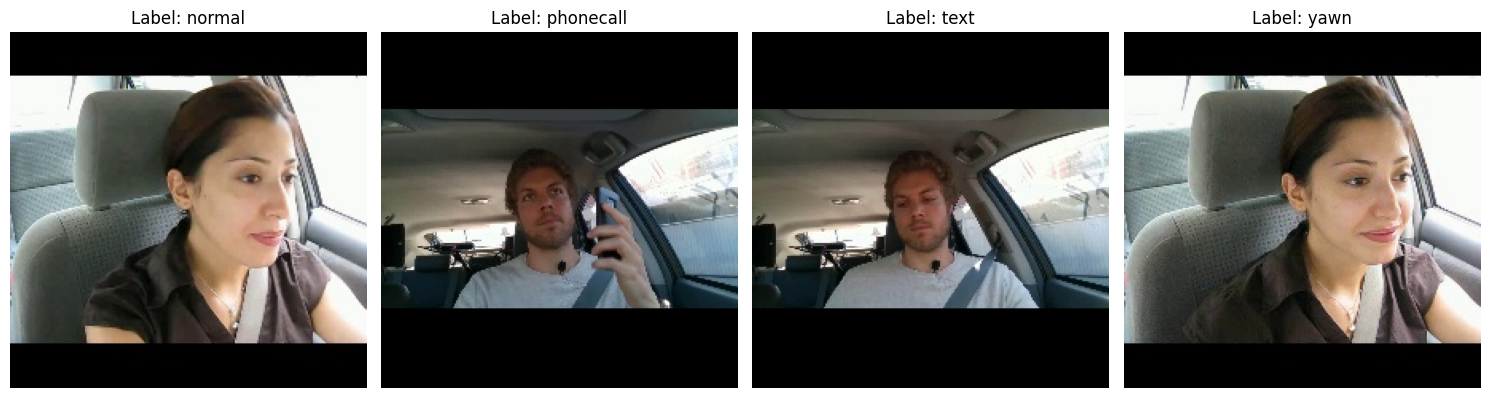

In [ ]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# DataFrame 불러오기 (이미 clip_id와 frame_path가 수정된 상태여야 함)
df = train_df.copy()

# 라벨별 하나씩 샘플 선택
sample_df = df.groupby("label").first().reset_index()

# 이미지 출력
plt.figure(figsize=(15, 5))
for idx, row in sample_df.iterrows():
    try:
        image_path = row["frame_path"]
        image = Image.open(image_path)

        plt.subplot(1, len(sample_df), idx + 1)
        plt.imshow(image)
        plt.title(f"Label: {row['label']}")
        plt.axis("off")
    except Exception as e:
        print(f"⚠️ Error loading {row['frame_path']}: {e}")

plt.tight_layout()
plt.show()

In [ ]:
train_df.drop(columns=['Unnamed: 0'], inplace=True)
# 오름차순 정렬
train_df = train_df.sort_values(by=["label", "dataset", "clip_id", "frame_no"]).reset_index(drop=True)
train_df.shape

(95268, 13)

In [ ]:
train_df.shape[0] /12

7939.0

In [ ]:
train_df.to_csv('/content/drive/MyDrive/DMS/data/splits/12frame_windows/train.csv', index=False)

In [ ]:
import pandas as pd
from pathlib import Path

# clip_id 매핑
clip_id_to_prefix = {
    "face_2019-03-07-16;31;48_9": "gB-9(File9)_s5",
    "face_2019-03-12-09;08;15_11": "gC-11(File11)_s5",
    "face_2019-03-12-09;18;58_14": "gC-14(File14)_s5",
    "face_2019-03-12-10;03;00_13": "gC-13(File13)_s5",
    "face_2019-03-12-10;35;20_10": "gB-10(File10)_s5",
    "face_2019-03-12-11;03;23_15": "gC-15(File15)_s5",
    "face_2019-03-13-09;06;49_5": "gA-5(File5)_s5",
    "face_2019-03-13-09;19;23_2": "gA-2(File2)_s5",
    "face_2019-03-13-09;36;25_3": "gA-3(File3)_s5",
    "face_2019-03-13-10;56;52_4": "gA-4(File4)_s5",
    "face_2019-03-13-13;37;11_6": "gB-6(File6)_s5",
    "face_2019-03-13-13;55;52_7": "gB-7(File7)_s5",
    "face_2019-03-13-14;10;09_8": "gB-8(File8)_s5",
    "face_2019-03-13-14;17;28_10": "gB-10(File10)_s5",
    "face_2019-03-14-09;56;52_12": "gC-12(File12)_s5",
    "face_2019-03-14-14;26;17_1": "gA-1(File1)_s5",
}

# clip_id 업데이트 함수
def safe_update_clip_id(row):
    old_clip_id = row["clip_id"]
    label = row["label"]
    dataset = row["dataset"]
    if label == "yawn" and dataset == "DMD":
        prefix = "_".join(old_clip_id.split("_")[:3])
        return f"{clip_id_to_prefix.get(prefix, 'UNKNOWN')}_{old_clip_id}"
    else:
        return old_clip_id

# frame_path 수정 함수
def update_frame_path(row):
    path = row["frame_path"]
    clip_id = row["clip_id"]
    label = row["label"]
    dataset = row["dataset"]

    if label == "yawn" and dataset == "DMD":
        return path.replace(
            "/DMD/dmd_frames_resized/yawn/",
            f"/processed/dmd_frames_resized/Yawn/{clip_id}/"
        )
    elif "YawDD dataset/YawDD_adjusted_frames_resized" in path:
        return path.replace(
            "/YawDD dataset/YawDD_adjusted_frames_resized/",
            "/processed/yawDD_adjusted_frames_resized/"
        )
    elif "/DMD/" in path:
        return path.replace("/DMD/", "/processed/")
    return path

# 전체 처리 함수
def process_and_save(df_path, save_path):
    df = pd.read_excel(df_path)
    df["clip_id"] = df.apply(safe_update_clip_id, axis=1)
    df["frame_path"] = df.apply(update_frame_path, axis=1)

    if 'Unnamed: 0' in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)

    df = df.sort_values(by=["label", "dataset", "clip_id", "frame_no"]).reset_index(drop=True)
    df.to_csv(save_path, index=False)
    print(f"✅ 저장 완료: {save_path}")

# 경로 설정
input_dir = Path("/content/drive/MyDrive/DMS/data/splits/resized_split_0514/frame_12")
output_dir = Path("/content/drive/MyDrive/DMS/data/splits/12frame_windows")
output_dir.mkdir(parents=True, exist_ok=True)

# 처리 실행
process_and_save(input_dir / "merge_train_12.xlsx", output_dir / "train.csv")
process_and_save(input_dir / "merge_val_12.xlsx", output_dir / "val.csv")
process_and_save(input_dir / "merge_test_12.xlsx", output_dir / "test.csv")


✅ 저장 완료: /content/drive/MyDrive/DMS/data/splits/12frame_windows/train.csv
✅ 저장 완료: /content/drive/MyDrive/DMS/data/splits/12frame_windows/val.csv
✅ 저장 완료: /content/drive/MyDrive/DMS/data/splits/12frame_windows/test.csv


In [ ]:
train_df = pd.read_csv(output_dir / "train.csv")
val_df = pd.read_csv(output_dir / "val.csv")
test_df = pd.read_csv(output_dir / "test.csv")

In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(95268, 13)
(16440, 13)
(27060, 13)


In [ ]:
print(train_df.shape[0] % 12 == 0.0)
print(val_df.shape[0] % 12 == 0.0)
print(test_df.shape[0] % 12 == 0.0)

True
True
True


In [ ]:
train_df.shape[0] + val_df.shape[0] + test_df.shape[0]

138768

### 24 frames

In [ ]:
# 경로 설정
input_dir = Path("/content/drive/MyDrive/DMS/data/splits/resized_split_0514/frame_24")
output_dir = Path("/content/drive/MyDrive/DMS/data/splits/24frame_windows")
output_dir.mkdir(parents=True, exist_ok=True)

# 처리 실행
process_and_save(input_dir / "merge_train_24.xlsx", output_dir / "train.csv")
process_and_save(input_dir / "merge_val_24.xlsx", output_dir / "val.csv")
process_and_save(input_dir / "merge_test_24.xlsx", output_dir / "test.csv")


✅ 저장 완료: /content/drive/MyDrive/DMS/data/splits/24frame_windows/train.csv
✅ 저장 완료: /content/drive/MyDrive/DMS/data/splits/24frame_windows/val.csv
✅ 저장 완료: /content/drive/MyDrive/DMS/data/splits/24frame_windows/test.csv


In [ ]:
output_dir = Path("/content/drive/MyDrive/DMS/data/splits/24frame_windows")

train_df = pd.read_csv(output_dir / "train.csv")
val_df = pd.read_csv(output_dir / "val.csv")
test_df = pd.read_csv(output_dir / "test.csv")

In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(82680, 13)
(14616, 13)
(23448, 13)


In [ ]:
WINDOW_SIZE = 24
print(train_df.shape[0] % WINDOW_SIZE == 0.0)
print(val_df.shape[0] % WINDOW_SIZE == 0.0)
print(test_df.shape[0] % WINDOW_SIZE == 0.0)

True
True
True


# 데이터누수 더블체크

In [ ]:
output_dir = Path("/content/drive/MyDrive/DMS/data/splits/12frame_windows")

train_df = pd.read_csv(output_dir / "train.csv")
val_df = pd.read_csv(output_dir / "val.csv")
test_df = pd.read_csv(output_dir / "test.csv")

In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(95268, 13)
(16440, 13)
(27060, 13)


In [ ]:
output_dir = Path("/content/drive/MyDrive/DMS/data/splits/24frame_windows")

train_df = pd.read_csv(output_dir / "train.csv")
val_df = pd.read_csv(output_dir / "val.csv")
test_df = pd.read_csv(output_dir / "test.csv")

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(82680, 13)
(14616, 13)
(23448, 13)


In [ ]:
train_df.shape[0]+val_df.shape[0]+test_df.shape[0]

120744

In [ ]:
def extract_subject_id(row):
    if row["dataset"] == "DMD":
        return row["clip_id"].split("(")[0]  # 'gE-27(File27)_...' → 'gE-27'
    elif row["dataset"].lower().startswith("yawdd"):
        clip_head = row["clip_id"].split("-")[0]  # '1-Female...' → '1'
        return f"{row['camera']}_{clip_head}"
    return "UNKNOWN"

# 사람 ID 추출
for df in [train_df, val_df, test_df]:
    df["subject_id"] = df.apply(extract_subject_id, axis=1)

# 데이터셋별 고유 subject_id 추출
train_subjects = set(train_df["subject_id"].unique())
val_subjects = set(val_df["subject_id"].unique())
test_subjects = set(test_df["subject_id"].unique())

# 교집합 확인
overlap_train_val = train_subjects & val_subjects
overlap_train_test = train_subjects & test_subjects
overlap_val_test = val_subjects & test_subjects

# 결과 출력
print(f"🔁 train ∩ val 겹치는 사람 수: {len(overlap_train_val)}")
print(f"🔁 train ∩ test 겹치는 사람 수: {len(overlap_train_test)}")
print(f"🔁 val ∩ test 겹치는 사람 수: {len(overlap_val_test)}")

# 상세 목록 출력 (필요 시)
if overlap_train_val:
    print("\n🔍 train ∩ val 겹치는 ID:")
    print(sorted(overlap_train_val))


🔁 train ∩ val 겹치는 사람 수: 4
🔁 train ∩ test 겹치는 사람 수: 5
🔁 val ∩ test 겹치는 사람 수: 1

🔍 train ∩ val 겹치는 ID:
['gA-1', 'gA-2', 'gA-3', 'gA-4']


## trainset resplit

In [ ]:
val_subjects = {'gA-1', 'gA-2', 'gA-3', 'gA-4'}
test_subjects = {'gA-5', 'gB-10', 'gB-6', 'gB-7', 'gB-8', 'gB-9', 'gE-26'}
# train은 그 외 모든 DMD_yawn subject

In [ ]:
# 전체 데이터 통합
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [ ]:
# 1. DMD yawn 데이터 분리
dmd_yawn_df = all_df[(all_df['dataset'] == 'DMD') & (all_df['label'] == 'yawn')].copy()

# 2. 기존 split에서 DMD-yawn 제거
def remove_dmd_yawn(df):
    return df[~((df['dataset'] == 'DMD') & (df['label'] == 'yawn'))].copy()

train_df = remove_dmd_yawn(train_df)
val_df = remove_dmd_yawn(val_df)
test_df = remove_dmd_yawn(test_df)

# 3. subject_id 없으면 생성
if "subject_id" not in dmd_yawn_df.columns:
    dmd_yawn_df["subject_id"] = dmd_yawn_df.apply(extract_subject_id, axis=1)

# 4. 분할 기준
val_ids = {"gA-1", "gA-2", "gA-3", "gA-4"}
test_ids = {"gA-5", "gB-10", "gB-6", "gB-7", "gB-8", "gB-9", "gE-26"}

# 실제 존재하는 subject만 사용
existing_ids = set(dmd_yawn_df["subject_id"].unique())
val_ids = val_ids & existing_ids
test_ids = test_ids & existing_ids
train_ids = existing_ids - val_ids - test_ids

# 5. dmd_yawn을 split
dmd_yawn_train = dmd_yawn_df[dmd_yawn_df["subject_id"].isin(train_ids)]
dmd_yawn_val = dmd_yawn_df[dmd_yawn_df["subject_id"].isin(val_ids)]
dmd_yawn_test = dmd_yawn_df[dmd_yawn_df["subject_id"].isin(test_ids)]

# 6. 다시 결합
final_train = pd.concat([train_df, dmd_yawn_train], ignore_index=True)
final_val = pd.concat([val_df, dmd_yawn_val], ignore_index=True)
final_test = pd.concat([test_df, dmd_yawn_test], ignore_index=True)


In [ ]:
print(final_train.shape)
print(final_val.shape)
print(final_test.shape)

(94668, 14)
(16692, 14)
(27408, 14)


In [ ]:
WINDOW_SIZE = 12
print(final_train.shape[0] % WINDOW_SIZE == 0.0)
print(final_val.shape[0] % WINDOW_SIZE == 0.0)
print(final_test.shape[0] % WINDOW_SIZE == 0.0)

True
True
True


In [ ]:
final_train.shape[0]+final_val.shape[0]+final_test.shape[0]

138768

In [ ]:
output_dir = Path("/content/drive/MyDrive/DMS/data/splits/12frame_windows")

def save_csv(df, save_path):
    df = df.sort_values(by=["label", "dataset", "clip_id", "frame_no"]).reset_index(drop=True)
    df.to_csv(save_path, index=False)

In [ ]:
save_csv(final_train, output_dir / 'final_train.csv')
save_csv(final_val, output_dir / 'final_val.csv')
save_csv(final_test, output_dir / 'final_test.csv')

In [ ]:
def extract_subject_id(row):
    if row["dataset"] == "DMD":
        return row["clip_id"].split("(")[0]  # 'gE-27(File27)_...' → 'gE-27'
    elif row["dataset"].lower().startswith("yawdd"):
        clip_head = row["clip_id"].split("-")[0]  # '1-Female...' → '1'
        return f"{row['camera']}_{clip_head}"
    return "UNKNOWN"

# 사람 ID 추출
for df in [final_train, final_val, final_test]:
    df["subject_id"] = df.apply(extract_subject_id, axis=1)

# 데이터셋별 고유 subject_id 추출
train_subjects = set(final_train["subject_id"].unique())
val_subjects = set(final_val["subject_id"].unique())
test_subjects = set(final_test["subject_id"].unique())

# 교집합 확인
overlap_train_val = train_subjects & val_subjects
overlap_train_test = train_subjects & test_subjects
overlap_val_test = val_subjects & test_subjects

# 결과 출력
print(f"🔁 train ∩ val 겹치는 사람 수: {len(overlap_train_val)}")
print(f"🔁 train ∩ test 겹치는 사람 수: {len(overlap_train_test)}")
print(f"🔁 val ∩ test 겹치는 사람 수: {len(overlap_val_test)}")

# 상세 목록 출력 (필요 시)
if overlap_train_val:
    print("\n🔍 train ∩ val 겹치는 ID:")
    print(sorted(overlap_train_val))


🔁 train ∩ val 겹치는 사람 수: 0
🔁 train ∩ test 겹치는 사람 수: 0
🔁 val ∩ test 겹치는 사람 수: 0


### 24frames

In [ ]:
output_dir = Path("/content/drive/MyDrive/DMS/data/splits/24frame_windows")

train_df = pd.read_csv(output_dir / "train.csv")
val_df = pd.read_csv(output_dir / "val.csv")
test_df = pd.read_csv(output_dir / "test.csv")

In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(82680, 13)
(14616, 13)
(23448, 13)


In [ ]:
# 전체 데이터 통합
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [ ]:
# 1. DMD yawn 데이터 분리
dmd_yawn_df = all_df[(all_df['dataset'] == 'DMD') & (all_df['label'] == 'yawn')].copy()

# 2. 기존 split에서 DMD-yawn 제거
def remove_dmd_yawn(df):
    return df[~((df['dataset'] == 'DMD') & (df['label'] == 'yawn'))].copy()

train_df = remove_dmd_yawn(train_df)
val_df = remove_dmd_yawn(val_df)
test_df = remove_dmd_yawn(test_df)

# 3. subject_id 없으면 생성
if "subject_id" not in dmd_yawn_df.columns:
    dmd_yawn_df["subject_id"] = dmd_yawn_df.apply(extract_subject_id, axis=1)

# 4. 분할 기준
val_ids = {"gA-1", "gA-2", "gA-3", "gA-4"}
test_ids = {"gA-5", "gB-10", "gB-6", "gB-7", "gB-8", "gB-9", "gE-26"}

# 실제 존재하는 subject만 사용
existing_ids = set(dmd_yawn_df["subject_id"].unique())
val_ids = val_ids & existing_ids
test_ids = test_ids & existing_ids
train_ids = existing_ids - val_ids - test_ids

# 5. dmd_yawn을 split
dmd_yawn_train = dmd_yawn_df[dmd_yawn_df["subject_id"].isin(train_ids)]
dmd_yawn_val = dmd_yawn_df[dmd_yawn_df["subject_id"].isin(val_ids)]
dmd_yawn_test = dmd_yawn_df[dmd_yawn_df["subject_id"].isin(test_ids)]

# 6. 다시 결합
final_train = pd.concat([train_df, dmd_yawn_train], ignore_index=True)
final_val = pd.concat([val_df, dmd_yawn_val], ignore_index=True)
final_test = pd.concat([test_df, dmd_yawn_test], ignore_index=True)


In [ ]:
print(final_train.shape)
print(final_val.shape)
print(final_test.shape)

(82224, 14)
(14784, 14)
(23736, 14)


In [ ]:
WINDOW_SIZE = 24
print(final_train.shape[0] % WINDOW_SIZE == 0.0)
print(final_val.shape[0] % WINDOW_SIZE == 0.0)
print(final_test.shape[0] % WINDOW_SIZE == 0.0)

True
True
True


In [ ]:
final_train.shape[0]+final_val.shape[0]+final_test.shape[0]

120744

In [ ]:
output_dir = Path("/content/drive/MyDrive/DMS/data/splits/24frame_windows")

def save_csv(df, save_path):
    df = df.sort_values(by=["label", "dataset", "clip_id", "frame_no"]).reset_index(drop=True)
    df.to_csv(save_path, index=False)

In [ ]:
save_csv(final_train, output_dir / 'final_train.csv')
save_csv(final_val, output_dir / 'final_val.csv')
save_csv(final_test, output_dir / 'final_test.csv')

In [ ]:
train_24f = pd.read_csv(output_dir / 'final_train.csv')
val_24f = pd.read_csv(output_dir / 'final_val.csv')
test_24f = pd.read_csv(output_dir / 'final_test.csv')

<ipython-input-107-ca9e978a6010>:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  train_24f = pd.read_csv(output_dir / 'final_train.csv')


In [ ]:
print(train_24f.shape)
print(val_24f.shape)
print(test_24f.shape)

(82224, 14)
(14784, 14)
(23736, 14)


In [ ]:
output_dir = Path("/content/drive/MyDrive/DMS/data/splits/12frame_windows")

train_12f = pd.read_csv(output_dir / 'final_train.csv')
val_12f = pd.read_csv(output_dir / 'final_val.csv')
test_12f = pd.read_csv(output_dir / 'final_test.csv')

print(train_12f.shape)
print(val_12f.shape)
print(test_12f.shape)

<ipython-input-109-5951c5893ae9>:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  train_12f = pd.read_csv(output_dir / 'final_train.csv')


(94668, 14)
(16692, 14)
(27408, 14)


In [ ]:
def extract_subject_id(row):
    if row["dataset"] == "DMD":
        return row["clip_id"].split("(")[0]  # 'gE-27(File27)_...' → 'gE-27'
    elif row["dataset"].lower().startswith("yawdd"):
        clip_head = row["clip_id"].split("-")[0]  # '1-Female...' → '1'
        return f"{row['camera']}_{clip_head}"
    return "UNKNOWN"

# 사람 ID 추출
for df in [final_train, final_val, final_test]:
    df["subject_id"] = df.apply(extract_subject_id, axis=1)

# 데이터셋별 고유 subject_id 추출
train_subjects = set(final_train["subject_id"].unique())
val_subjects = set(final_val["subject_id"].unique())
test_subjects = set(final_test["subject_id"].unique())

# 교집합 확인
overlap_train_val = train_subjects & val_subjects
overlap_train_test = train_subjects & test_subjects
overlap_val_test = val_subjects & test_subjects

# 결과 출력
print(f"🔁 train ∩ val 겹치는 사람 수: {len(overlap_train_val)}")
print(f"🔁 train ∩ test 겹치는 사람 수: {len(overlap_train_test)}")
print(f"🔁 val ∩ test 겹치는 사람 수: {len(overlap_val_test)}")

# 상세 목록 출력 (필요 시)
if overlap_train_val:
    print("\n🔍 train ∩ val 겹치는 ID:")
    print(sorted(overlap_train_val))


🔁 train ∩ val 겹치는 사람 수: 0
🔁 train ∩ test 겹치는 사람 수: 0
🔁 val ∩ test 겹치는 사람 수: 0
